# Getting masks from mannually labeled images

In [1]:
import numpy as np
from PIL import Image
from scipy import ndimage
from skimage.measure import regionprops
import os

def get_masks(input_dir, outpur_dir):
    images = os.listdir(input_dir)
    for image in images:
        # Open image and make RGB and HSV versions
        RGBim = Image.open(input_dir + image)
        HSVim = RGBim.convert('HSV')

        # Make numpy versions
        RGBna = np.array(RGBim)
        HSVna = np.array(HSVim)

        # Extract Hue
        H = HSVna[:,:,0]

        # Find all green pixels, i.e. where 100 < Hue < 140
        lo,hi = 100,140
        # Rescale to 0-255, rather than 0-360 because we are using uint8
        lo = int((lo * 255) / 360)
        hi = int((hi * 255) / 360)
        green = np.where((H>lo) & (H<hi))
        not_green = np.where((H<=lo) | (H>=hi))

        # Make all green pixels black in original image
        RGBna[green] = [0,0,0]
        RGBna[not_green] = [255,255,255]

        count = green[0].size
        print("Pixels matched: {}".format(count))

        labeled, nr_objects = ndimage.label(RGBna != [255,255,255]) 
        props = regionprops(labeled)

        print('Number of objects: ' + str(len(props)))
        new_mask = np.invert(np.copy(RGBna))

        for prop in range(len(props)):
            if props[prop].area > 100:
                [X, Y, W, H, a, b] = props[prop].bbox

                new_mask[X:H, Y:a] = props[prop].image_convex.astype(np.uint8)*255

        Image.fromarray(new_mask).save(outpur_dir + image.split(".")[0] + ".png", "PNG", quality=100)

In [2]:
base_path = "C:\\Igor\\dali\\tumor_regions_segmentation-main\\datasets\\BONE_CHANNELS\\"
training_images_path = base_path + "training\\labelled_images\\png\\"
training_masks_path = base_path + "training\\annotations\\"

testing_images_path = base_path + "testing\\labelled_images\\"
testing_masks_path = base_path + "testing\\annotations\\"

In [42]:
import matplotlib.pyplot as plt

def fill_contours(arr):
    return np.maximum.accumulate(arr,1) & np.maximum.accumulate(arr[:,::-1],1)[:,::-1]

def get_masks_1(path_to_image):
    # Open image and make RGB and HSV versions
    RGBim = Image.open(path_to_image)
    HSVim = RGBim.convert('HSV')
    # Make numpy versions
    RGBna = np.array(RGBim)
    HSVna = np.array(HSVim)
    # Extract Hue
    H = HSVna[:,:,0]
    # Find all green pixels, i.e. where 100 < Hue < 140
    lo,hi = 100,140
    # Rescale to 0-255, rather than 0-360 because we are using uint8
    lo = int((lo * 255) / 360)
    hi = int((hi * 255) / 360)
    green = np.where((H>lo) & (H<hi))
    not_green = np.where((H<=lo) | (H>=hi))
    # Make all green pixels black in original image
    RGBna[green] = [0,0,0]
    RGBna[not_green] = [255,255,255]
    #plt.imshow(RGBna)#Image.fromarray(RGBna).show()
    return np.invert(RGBna)

# Preenche contornos        
def get_masks_2(RGBna, mean_props_area):
    labeled, nr_objects = ndimage.label(RGBna != [0,0,0]) 
    props = regionprops(labeled)

    new_mask = np.copy(RGBna)
    
    for prop in range(len(props)):
        if props[prop].area > (1)*mean_props_area:
            continue
        else:
            [X, Y, W, H, a, b] = props[prop].bbox
            new_mask[X:H, Y:a] = props[prop].image_filled.astype(np.uint8)*0
       
            
    #plt.imshow(new_mask)#Image.fromarray(new_mask).show()
    return new_mask

def get_mean_props_area(RGBna):
    labeled, nr_objects = ndimage.label(RGBna != [0,0,0]) 
    props = regionprops(labeled)

    new_mask = np.copy(RGBna)
    mean_props_area = 0
    for prop in range(len(props)):
        mean_props_area = mean_props_area + props[prop].area
    
    mean_props_area = mean_props_area/len(props)
    return mean_props_area

def get_masks_3(RGBna, mean_props_area):
    labeled, nr_objects = ndimage.label(RGBna != [0,0,0]) 
    props = regionprops(labeled)

    new_mask = np.copy(RGBna)

    for prop in range(len(props)):
        [X, Y, W, H, a, b] = props[prop].bbox
        new_mask[X:H, Y:a] = fill_contours(props[prop].image_filled.astype(np.uint8)*255)#props[prop].image_filled.astype(np.uint8)*255
        
            
    #plt.imshow(new_mask)#Image.fromarray(new_mask).show()
    return new_mask

# Make numpy versions
step_0 = np.array(Image.open(training_images_path + "301.png"))  
step_1 = get_masks_1(training_images_path + "301.png")

mean = get_mean_props_area(step_1)

step_2 = get_masks_2(step_1, mean)
step_3 = get_masks_3(step_2, mean)

if not os.path.exists(training_masks_path):
    os.mkdir(training_masks_path)
    
if not os.path.exists(testing_masks_path):
    os.mkdir(testing_masks_path)

AttributeError: 'Axes' object has no attribute 'savefig'

<Figure size 640x480 with 0 Axes>

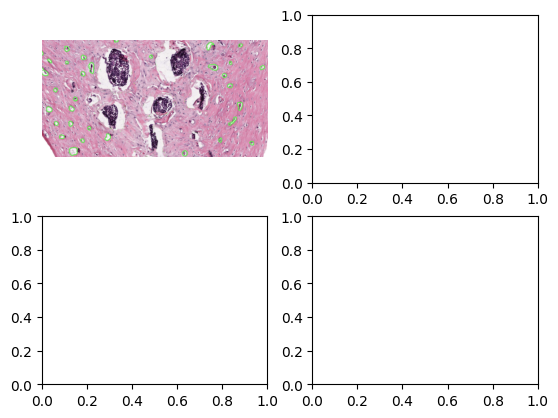

In [43]:
plt.figure()
#subplot(r,c) provide the no. of rows and columns
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
ax1.imshow(step_0[6800:8000,2700:5000])
#ax1.set_title('(a)')
ax1.axis('off')
ax1.savefig('C:\\\Igor\\output1.png', dpi=300)

ax2.imshow(step_1[6800:8000,2700:5000])
#ax2.set_title('(b)')
ax2.axis('off')
ax2.savefig('C:\\\Igor\\output2.png', dpi=300)

ax3.imshow(step_2[6800:8000,2700:5000])
#ax3.set_title('(c)')
ax3.axis('off')
ax3.savefig('C:\\\Igor\\output3.png', dpi=300)

ax4.imshow(step_3[6800:8000,2700:5000])
#ax4.set_title('(d)')
ax4.axis('off')
ax4.savefig('C:\\\Igor\\output4.png', dpi=300)

plt.tight_layout()
plt.savefig('C:\\\Igor\\output.png', dpi=300)

In [ ]:
if not os.path.exists(training_masks_path):
    os.mkdir(training_masks_path)
    
if not os.path.exists(testing_masks_path):
    os.mkdir(testing_masks_path)

get_masks(training_images_path, training_masks_path)
#get_masks(testing_images_path, testing_masks_path)


In [ ]:
def make_square(im, min_size=256, fill_color=(0, 0, 0, 255)):
    x, y = im.size
    size = max(min_size, x, y)
    new_im = Image.new('RGBA', (size, size), fill_color)
    new_im.paste(im, (int((size - x)/2), 0))
    return new_im

def resize_images(input_dir, outpur_dir, fill_color='black'):
    images = os.listdir(input_dir)

    for image in images:
        RGBim = Image.open(input_dir + image)
        if fill_color == 'black':
            resized = make_square(RGBim)
        else:
            resized = make_square(RGBim, fill_color=(255,255,255,255))
            
        resized.save(outpur_dir + image.split(".")[0] + ".png", "PNG", quality=100)

In [ ]:
# Resizing masks
resize_images(training_masks_path, training_masks_path)
resize_images(testing_masks_path, testing_masks_path)

# Resizing WSI images
training_wsi_path = base_path + "training\\wsi\\"
resized_training_wsi_path = base_path + "training\\bones\\"
resize_images(training_wsi_path, resized_training_wsi_path, fill_color='white')

testing_wsi_path = base_path + "testing\\wsi\\"
resized_testing_wsi_path = base_path + "testing\\bones\\"
resize_images(testing_wsi_path, resized_testing_wsi_path, fill_color='white')